In [2]:
import sys, os

# ADD YOUR PATH TO pyFM or `pip install pyFM`
sys.path.append('../../pyFM/')


In [4]:
import numpy as np
import torch as th


from pyFM.mesh import TriMesh
import pyFM.spectral as spectral
import matplotlib.pyplot as plt

# Importing RHM adds the path to densemaps to the system path
import RHM

import densemaps.numpy.maps as maps_np
import densemaps.torch.maps as maps_th

In [5]:
mesh1 = TriMesh("./data/mesh1.off", area_normalize=True, center=True).process(k=50, intrinsic=True)
mesh2 = TriMesh("./data/mesh2.off", area_normalize=True, center=True).process(k=50, intrinsic=True)

In [6]:
from RHM.geometry_utils import knn_query
p2p_21 = knn_query(mesh1.vertices, mesh2.vertices)


In [8]:
def get_init_map_np(mesh1, mesh2):
    """Computes an initial map from NN query.

    Numpy version.
    Projects into functional map then back to pointwise map.
    """
    # compute the spectral bases
    k=30
    p2p_21 = knn_query(mesh1.vertices, mesh2.vertices)
    FM_12 = spectral.mesh_p2p_to_FM(p2p_21, mesh1, mesh2, dims=k)

    emb1 = mesh1.eigenvectors[:,:k] @ FM_12.T
    emb2 = mesh2.eigenvectors[:,:k]
    P21 = maps_np.EmbP2PMap(emb1, emb2)
    return P21

In [9]:
def get_init_map_th(mesh1, mesh2):
    """Computes an initial map from NN query.

    Numpy version.
    Projects into functional map then back to pointwise map.
    """
    # compute the spectral bases
    k=10
    p2p_21 = knn_query(mesh1.vertices, mesh2.vertices)
    FM_12 = spectral.mesh_p2p_to_FM(p2p_21, mesh1, mesh2, dims=k)
    
    emb1 = th.from_numpy((mesh1.eigenvectors[:,:k] @ FM_12.T).astype(np.float32))
    emb2 = th.from_numpy(mesh2.eigenvectors[:,:k].astype(np.float32))

    P21 = maps_th.EmbP2PMap(emb1, emb2)
    return P21

In [12]:
P21_init = get_init_map_th(mesh1, mesh2)
P12_init = get_init_map_th(mesh2, mesh1)

In [14]:
# import RHM.numpy.rhm_solver
import RHM.torch.rhm_solver

In [15]:
res_th = RHM.torch.rhm_solver.rhm_refine(mesh1, mesh2, P12_init, P21_init, alpha=5e-4, beta=5e-3, nit_max=200, nit_min=20, abs_tol=1e-9, n_jobs=10, log=True, precise=True, last_precise=True, device='cuda:1', verbose=True)

/home/robin/.conda/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/robin/.conda/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

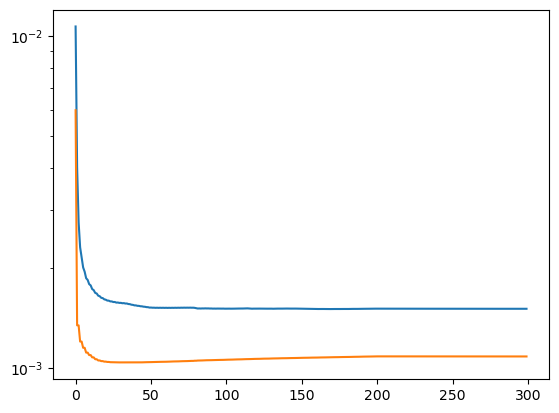

In [16]:
# Plot energy
plt.semilogy([x[-1] for x in res_th[2]], label='Total')
plt.semilogy([x[0] for x in res_th[2]], label='Dirichlet')

In [20]:
P21_rhm = res_th[1]

uv1 = mesh1.get_uv(0,1,2)

uv2 = P21_rhm._to_np_sparse() @ uv1

os.makedirs("test_res", exist_ok=True)
mesh1.export_texture("test_res/mesh1.obj", uv=uv1)
mesh2.export_texture("test_res/mesh2.obj", uv=uv2)
mesh2.export_texture("test_res/mesh2_init.obj", uv=P21_init._to_np_sparse() @ uv1)


Copy texture at test_res/texture_1.jpg


In [13]:
res_np = RHM.numpy.rhm_solver.rhm_refine(mesh1, mesh2, P12_init, P21_init, alpha=5e-4, beta=5e-3, nit_max=200, emb_dim=10, nit_min=20, abs_tol=1e-9, n_jobs=10, log=True, precise=True, last_precise=True, verbose=True)

/home/robin/.conda/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/robin/.conda/envs/py39/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 